In [1]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [2]:
%cd ./gdrive/MyDrive/

/content/gdrive/MyDrive


In [3]:
import os
if not os.path.exists('SVHN_Yolo'):
    os.makedirs('SVHN_Yolo')

In [4]:
%cd SVHN_Yolo/

/content/gdrive/MyDrive/SVHN_Yolo


In [5]:
#!git clone https://github.com/AlexeyAB/darknet.git
%cd darknet

/content/gdrive/MyDrive/SVHN_Yolo/darknet


In [6]:
#make

In [7]:
!chmod +x darknet

In [24]:
####
### ALL THE FOLLOWING CELLS MUST BE RUN IN darknet/data/
###
%cd data/

/content/gdrive/My Drive/SVHN_Yolo/darknet/data


In [9]:

#!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29

In [15]:
####### Uncomment for training
!unrar x ./extra.rar /content

Streaming output truncated to the last 5000 lines.
Extracting  /content/extra/955.png                                        97%  OK 
Extracting  /content/extra/9550.png                                       97%  OK 
Extracting  /content/extra/95500.png                                      97%  OK 
Extracting  /content/extra/95501.png                                      97%  OK 
Extracting  /content/extra/95502.png                                      97%  OK 
Extracting  /content/extra/95503.png                                      97%  OK 
Extracting  /content/extra/95504.png                                      97%  OK 
Extracting  /content/extra/95505.png                                      97%  OK 
Extracting  /content/extra/95506.png                                      97%  OK 
Extracting  /content/extra/95507.png                                      97%  OK 
Extracting  /content/extra/95

In [12]:
#@title Libraries
import pandas as pd 
import numpy as np
import cv2 as cv
import os
from tqdm import tqdm
import json as json
from google.colab.patches import cv2_imshow
from shutil import copyfile

In [13]:
#@title Functions definitions


IMG_DIR = '/content/extra'
TRAIN_DIR = '/content/train'
TEST_DIR = '/content/test'
VALID_DIR = '/content/valid'
TEST_LABEL='test.csv'
TRAIN_LABEL='train1.csv'
VALID_LABEL='valid.csv'
TRAIN_LIST_PATH = 'train.txt'
TEST_LIST_PATH = 'test.txt'
VALID_LIST_PATH = 'valid.txt'
DATA_FILE = 'obj.data'

def split_train_valid(TEST_SIZE = 0.1):
    '''
        This function split the train.csv label file to train1.csv as training
        set and valid.csv as the validation set
        INPUT:
            - TEST_SIZE: relative size of the validation set to the original 
                set
        OUTPUT: NONE
    '''
    x = pd.read_csv('train.csv')
    
    names = x.name.unique()
    train_name = names[:int(len(names)*(1-TEST_SIZE))]
    valid_name = names[int(len(names)*(1-TEST_SIZE)):]

    train_df = x[x['name'].isin(train_name)]
    valid_df = x[x['name'].isin(valid_name)]
    train_df.to_csv('train1.csv', index = False)
    valid_df.to_csv('valid.csv', index= False)
    print('Done.')
    return None

def moveImagetoTrainTest(DIR, LABEL):
    '''
        This function moves the images from the extra folder to the 
        corresponding folder based on the label files. For example: images that
        are in the train1.csv would be move the /content/train/ folder
        INPUT:
            - DIR: diretory to copy the images to
            - LABEL: Label that contains the name and label of the images
        OUTPUT:
            NONE
    '''
    if not os.path.exists(DIR):
        os.mkdir(DIR)
    label = pd.read_csv(LABEL)
    for im in tqdm(label['name'].unique()):
        copyfile(os.path.join(IMG_DIR, im), os.path.join(DIR,im))
    print('DONE.')
    return None 


def OneFuncToDoEverything(resultJson = 'result.json', steps =20, disp = 1,
                          return_df = 0, conf_threshold = 0):
    '''
        This function have two purpose:
        1. Read the result.json file that contains the predicted objects, and
           draw boxes on the image before print to command line
        2. Create the .csv file with all the objects for every detections in
            result.json
        INPUT:
            - resultJson: name of the json file to read
            - steps: number of objects to show/ record in the .csv file
            - disp: 1 to show images, 0 to not show
            - return_df: 1 if output the csv file
            - threshold: confidence threshold to draw/ record detected object
        OUTPUT:
            -if return_df = 0, return the .csv file with the info of the
            detection

    '''
    font = cv.FONT_HERSHEY_SIMPLEX
    COL_NAMES = ['name','left','top','width','height', 'score','label']
    with open(resultJson) as json_file:
        data = json.load(json_file)
        if steps == 'a':
            steps = len(data)
        if return_df ==1:
            df = pd.DataFrame(columns=COL_NAMES)

        for i in range(steps):
            img_path = data[i]['filename']
            
            if disp ==1:
                print(img_path)
            objs = data[i]['objects']
            I = cv.imread(img_path)
            img_h = I.shape[0]
            img_w = I.shape[1]
           
            for j in range(len(objs)-1,-1,-1):
                num = objs[j]['name']
                cx = objs[j]['relative_coordinates']['center_x']
                cy = objs[j]['relative_coordinates']['center_y']
                w = objs[j]['relative_coordinates']['width']
                h = objs[j]['relative_coordinates']['height']

                conf = objs[j]['confidence']
                if conf < conf_threshold:
                    continue
                
                x1= (int((cx-0.5*w)*img_w),int((cy-0.5*h)*img_h))
                x2= (int((cx+0.5*w)*img_w),int((cy+0.5*h)*img_h))
                x3= (int((cx)*img_w),int((cy+0.45*h)*img_h))
                if(disp==1):
                    print(num, conf)


                cv.rectangle(I , x1 , x2, (0,255,0) ,2)
                cv.putText(I,num,x3, font, w*img_w*0.01,(255,255,0),1,cv.LINE_AA)
                
                if return_df == 1:
                    label_to_add= pd.DataFrame([[img_path[14:], x1[0],x1[1],int(w*img_w), int(h*img_h),conf, num]], columns = COL_NAMES)
                    df=df.append(label_to_add)
            
            if disp ==1 :
                cv2_imshow(I)
                print('========================================================')
        if return_df ==1:
            return df
        return None
        #input()


def makelabel(labelin, labelout, dir):  
    ''' 
        INPUT:
            -labelin : path to input csv label, in left/top format
            -labelout: path to ouput csv label, in center format
            -dir: directory to write .txt label, yolo format
        OUTPUT: None
    '''
    x = pd.read_csv(labelin)
    print('\n[INFO]: Numbers of images: ', len(x['name'].unique()))
    print('[INFO]: Numbers of labels: ', len(x), '\n\n\n')
   
    x['left'] = x['left'] + (0.5*x['width']).astype(np.int)
    x['top'] = x['top'] + (0.5*x['height']).astype(np.int)
    

    x['label'] = x['label'] % 10

    x.to_csv(labelout)
    
    imglist = x['name'].unique()
    i = 0

    if not (os.path.exists(dir)):
            os.mkdir(dir)

    for im_name in tqdm(imglist, position =0, leave = True):
    
        img = cv.imread('/content/extra/' + im_name)
        h = img.shape[0]
        w = img.shape[1]
        
        WRITE_PATH = os.path.join(dir,im_name.replace('.png', '.txt'))


        if (os.path.exists(WRITE_PATH)):
            os.remove(WRITE_PATH)

        file = open(WRITE_PATH,'a')

        while((x['name'][i] == im_name)):
            
            file.write(str(x['label'][i]) + ' ' + str(x['left'][i]/w) +' '
            + str(x['top'][i]/h) +' '+str(x['width'][i]/w) +' '
            + str(x['height'][i]/h)+'\n' )
            i+=1
            if (i == len(x)):
                break
        
        file.close()
    file = open(os.path.join(dir,'classes.txt'),'w')
    for i in range(10):
        file.write(str(i)+'\n')
    file.close()


    print('\n\n\nDone.')
        
    return None

def createImgList(PATH,LABEL,DIR):
    '''
        Create the image list and put all of the path in 1 .txt file
        INPUT:
            -PATH: PATH to the .txt output. e.g train.txt
            -LABEL: label file
            -DIR: Directory of the image.
        OUTPUT: None
    '''
    label_df = pd.read_csv(LABEL)
    if os.path.exists(PATH):
        os.remove(PATH)
    file = open(PATH,'a')
    for im in tqdm(label_df['name'].unique()):
        file.write(os.path.join(DIR,im)+'\n')
    file.close()
    print('\n\nDone.')

In [25]:
#@title Run functions to prepare training process
#Split train/valid data from train set

print('Splitting train/valid:')
split_train_valid()
print('Moving image from original folder')
moveImagetoTrainTest(TRAIN_DIR, TRAIN_LABEL)
moveImagetoTrainTest(TEST_DIR, TEST_LABEL)
moveImagetoTrainTest(VALID_DIR, VALID_LABEL)

print('Creating labels for each folder')
makelabel('train1.csv', 'train_yolo_label.csv', '/content/train/')
makelabel('test.csv', 'test_yolo_label.csv', '/content/test/')
makelabel('valid.csv', 'valid_yolo_label.csv', '/content/valid/')

print('Creating image lists')
createImgList(TRAIN_LIST_PATH,TRAIN_LABEL,TRAIN_DIR)
createImgList(TEST_LIST_PATH,TEST_LABEL,TEST_DIR)
createImgList(VALID_LIST_PATH,VALID_LABEL,VALID_DIR)

Splitting train/valid:


  5%|▌         | 1071/20355 [00:00<00:01, 10709.81it/s]

Done.
Moving image from original folder


100%|██████████| 20355/20355 [00:08<00:00, 2379.72it/s]


DONE.


 15%|█▌        | 341/2262 [00:00<00:00, 3122.27it/s]

DONE.


  0%|          | 0/20355 [00:00<?, ?it/s]

DONE.
Creating labels for each folder

[INFO]: Numbers of images:  20355
[INFO]: Numbers of labels:  53693 





  1%|          | 120/9693 [00:00<00:07, 1198.98it/s]




Done.

[INFO]: Numbers of images:  9693
[INFO]: Numbers of labels:  25554 





  5%|▌         | 120/2262 [00:00<00:01, 1186.47it/s]




Done.

[INFO]: Numbers of images:  2262
[INFO]: Numbers of labels:  5960 





100%|██████████| 2262/2262 [00:00<00:00, 454230.65it/s]




Done.
Creating image lists


Done.


Done.


Done.


In [17]:
#@title Creating necessary files
'''
    Create data/obj.names: containing the name list of the object
'''
NAMES_FILE = 'obj.names'
file = open(NAMES_FILE, 'w')
for i in range(0,10):
    file.write(str(i)+'\n')
file.close()
print('Done.')

'''
    Create data/obj.data that contains path to train list, test list, names list
'''

file = open(DATA_FILE,'w')
file.write('classes= 10\n')
file.write('train= '+os.path.join('data',TRAIN_LIST_PATH)+'\n')
file.write('valid= '+os.path.join('data',VALID_LIST_PATH)+'\n')
file.write('names= '+os.path.join('data',NAMES_FILE)+'\n')
file.write('backup= backup/')
file.close()

print('train= '+os.path.join('data',TRAIN_LIST_PATH)+'\n')
print('valid= '+os.path.join('data',VALID_LIST_PATH)+'\n')
print('names= '+os.path.join('data',NAMES_FILE)+'\n')
print('Done.')

Done.
train= data/train.txt

valid= data/valid.txt

names= data/obj.names

Done.


In [18]:
#################### NOW cd TO THE MAIN DARKNET FOLDER
%cd ..

/content/gdrive/My Drive/SVHN_Yolo/darknet


In [ ]:
#TRAINING
#!./darknet detector train ./data/obj.data cfg/svhn.cfg ./data/tiny-yolo.conv.29 -dont_show -mjpeg_port 8090 -map


In [ ]:
pwd

'/content/gdrive/My Drive/SVHN_Yolo/darknet'

In [19]:
##TESTING
!./darknet detector test data/obj.data cfg/svhn.cfg backup/svhn_best.weights -ext_output -dont_show -out result.json ./data/demo/1.png

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
Cannot load image data/labels/32_0.png
Cannot load image data/labels/33_0.png
Cannot load image data/labels/34_0.png
Cannot load image data/labels/35_0.png
Cannot load image data/labels/36_0.png
Cannot load image data/labels/37_0.png
Cannot load image data/labels/38_0.png
Cannot load image data/labels/39_0.png
Cannot load image data/labels/40_0.png
Cannot load image data/labels/41_0.png
Cannot load image data/labels/42_0.png
Cannot load image data/labels/43_0.png
Cannot load image data/labels/44_0.png
Cannot load image data/labels/45_0.png
Cannot load image data/labels/46_0.png
Cannot load image data/labels/47_0.png
Cannot load image data/labels/48_0.png
Cannot load image data/labels/49_0.png
Cannot load image data/labels/50_0.png
Cannot load image data/labels/51_0.png
Cannot load image data/labels/52_0.png
Cannot load image data/labels/53_0.png
Cannot load image data/labels/54_0.png
Cannot load image dat

./data/demo/1.png
0 0.646793
3 0.49196
5 0.392217
8 0.3965


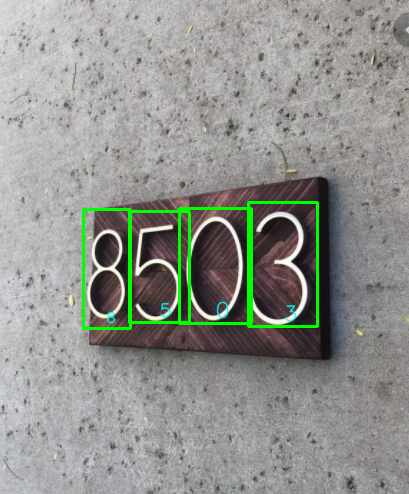

In [20]:
OneFuncToDoEverything(steps='a', disp =1, return_df =0)
# print(df.info())
# df.to_csv('test_infer.csv', index = False)

In [ ]:
#@title unused code, but usable
x = pd.read_csv('valid.csv')
I = cv.imread(os.path.join('/content','valid', x['name'][0]))
print(os.path.join('content','valid', x['name'][0]))
print(type(I))
print(I.shape)
f = open('/content/valid/'+x.name[0].replace('.png','.txt'))
labels = f.read().splitlines()
f.close()
#boxes = np.zeros(len(labels),2)
for i in range(len(labels)):
    labels[i] = list(map(float,labels[i].split(' ')))
    print(labels[i])
    x1 = (int((labels[i][1] - 0.5*labels[i][3])*I.shape[1]), int((labels[i][2] - 0.5*labels[i][4])*I.shape[0]))
    x2 = (int((labels[i][1] + 0.5*labels[i][3])*I.shape[1]), int((labels[i][2] + 0.5*labels[i][4])*I.shape[0]))

    c1 = (int(labels[i][1]*I.shape[1]-2), int(labels[i][2]*I.shape[0]-2))
    c2 = (int(labels[i][1]*I.shape[1]+2), int(labels[i][2]*I.shape[0]+2))
    print(x1)
    print(x2)
    cv.rectangle(I ,x1 , x2, (0,255,0) ,1)
    cv.rectangle(I ,c1 , c2, (0,255,255) ,1)



print(labels)
#cv.rectangle(img,())
#print(I)
cv2_imshow(I)
